<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Numerical PDE</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> SBP-SAT approximation of the scalar advection equation </div>
        </div>
    </div>
</div>

In [1]:
# Parameters initialization and plotting the simulation
# Import necessary routines
import numpy as np
import matplotlib.pyplot as plt
import timeit

plt.switch_backend("nbagg")           # plots within this notebook

In [2]:
# FUNCTION decimal range step value  
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step

In [3]:
# Implement the SBP-SAT scheme using 4th order Sbp

def d_x(u, nx, dx):
    # finite difference approximation for the first derivatives du/dx
    
    # initialise the derivative vector
    ux = 0*u         
    # fourth order accurate case        
    ################################################# 
    # calculate partial derivatives on the boundaries:(0,1,2,3, : nx-4, nx-3, nx-2, nx-1)
    # with one-sided difference operators
        
    ux[0] = -24./17*u[0] + 59./34*u[1]  - 4./17*u[2] - 3./34*u[3]
    ux[1] = -1./2*u[0] + 1./2*u[2] ;
    ux[2] = 4./43*u[0] - 59./86*u[1]  + 59./86*u[3] - 4./43*u[4]
    ux[3] = 3./98*u[0] - 59./98*u[2]  + 32./49*u[4] - 4./49*u[5]


    ux[nx-1] = 24./17*u[nx-1] - 59./34*u[nx-2]  + 4./17*u[nx-3] + 3./34*u[nx-4]
    ux[nx-2] = 1./2*u[nx-1] - 1./2*u[nx-3] ;
    ux[nx-3] = -4./43*u[nx-1] + 59./86*u[nx-2]- 59./86*u[nx-4]+ 4./43*u[nx-5]
    ux[nx-4] = -3./98*u[nx-1] + 59./98*u[nx-3]- 32./49*u[nx-5]+ 4./49*u[nx-6]
    
    # interior points x_j (j = 4, ... nx-5)     
    #------------------------------------------------------------------------------------------------------------------------------
    for j in range(4, nx-4):
        ux[j] = 1./12*u[j-2] - 2./3*u[j-1] + 2./3*u[j+1] - 1./12*u[j+2]

    ux[:] = ux/dx
                        
    return ux


In [4]:
def mms_func(x,t,U,V,H,g,f):
    import numpy as np
    omega = 1
    k = 5
    e = 0.2
    L = x[-1]-x[0]
    
    u = np.cos(omega*np.pi*t)*np.sin(k*np.pi*x/L)
    v = np.sin(omega*np.pi*t)*np.cos(k*np.pi*x/L)
    h = 1 + e*np.cos(omega*np.pi*t)*np.cos(k*np.pi*x/L)
    
    du_dt =  -omega*np.pi*np.sin(omega*np.pi*t)*np.sin(k*np.pi*x/L)
    du_dx = k/L*np.pi*np.cos(omega*np.pi*t)*np.cos(k*np.pi*x/L)
    
    dv_dt =  omega*np.pi*np.cos(omega*np.pi*t)*np.cos(k*np.pi*x/L)
    dv_dx = -k/L*np.pi*np.sin(omega*np.pi*t)*np.sin(k*np.pi*x/L)
    
    dh_dt = -e*omega*np.pi*np.sin(omega*np.pi*t)*np.cos(k*np.pi*x/L)
    dh_dx = -e*k/L*np.pi*np.cos(omega*np.pi*t)*np.sin(k*np.pi*x/L)
    
    f_u = du_dt + U*du_dx + g*dh_dx - f*v
    f_v = dv_dt + U*dv_dx + f*u
    f_h = dh_dt + H*du_dx + U*dh_dx
    return u,v,h,f_u,f_v,f_h

In [5]:
def w_variables(uu,vv,hh,g,c,n,uu_e,vv_e,hh_e):
    w1 = 1/(2**(1/2))*(g*(hh-hh_e)/c-(n[0]*(uu-uu_e)+n[1]*(vv-vv_e)))
    w2 = - n[1]*(uu-uu_e)+ n[0]*(vv-vv_e)
    w3 = 1/(2**(1/2))*(g*(hh-hh_e)/c+(n[0]*(uu-uu_e)+n[1]*(vv-vv_e)))
    return w1,w2,w3

In [6]:
# Compute the RHS:  -(1/rou)du/dx + SAT
def rate(u, v, h, nx, dx, dt, U, V, H, g, f, t, mms):

    # set penalty parameter   
    H1 = (17/48)*dx
    
    # Exact solution
    u_e,v_e,h_e,f_u,f_v,f_h = 0*u,0*u,0*u,0*u,0*u,0*u
    if mms:
        u_e,v_e,h_e,f_u,f_v,f_h = mms_func(x,t,U,V,H,g,f)
        
    #  compute numerical derivative of u 
    r_u = -U*d_x(u, nx, dx) - g*d_x(h, nx, dx) + f*v +f_u
    r_v = -U*d_x(v, nx, dx) - f*u + f_v
    r_h = -H*d_x(u, nx, dx) - U*d_x(h, nx, dx) + f_h
    
    # x = 0
    n = [-1,0]
    w1,w2,w3 = w_variables(u[0],v[0],h[0],g,c,n,u_e[0],v_e[0],h_e[0])
    omega = n[0]*U + n[1]*V
    tau1 = (omega-c)/H1
    tau2 = omega/H1
    tau3 = (omega+c)/H1
    G_01 = tau1*w1/(2**(1/2))
    G_02 = -tau2*w2
    G_03 = c*tau1*w1/(2**(1/2)*g)
    
    # penalize the boundary term
    r_u[0] = r_u[0] + G_01
    r_v[0] = r_v[0] + G_02
    r_h[0] = r_h[0] + G_03

    return r_u,r_v,r_h


In [7]:
# function of RK4
def RK4(u, v, h, nx, dx, dt, U, V, H, g, f, t, mms):
    k1_u,k1_v,k1_h = rate(u, v, h, nx, dx, dt, U, V, H, g, f, t, mms)
    k2_u,k2_v,k2_h = rate(u+dt/2*k1_u, v+dt/2*k1_v, h+dt/2*k1_h, nx, dx, dt, U, V, H, g, f, t+0.5*dt, mms)
    k3_u,k3_v,k3_h = rate(u+dt/2*k2_u, v+dt/2*k2_v, h+dt/2*k2_h, nx, dx, dt, U, V, H, g, f, t+0.5*dt, mms)
    k4_u,k4_v,k4_h = rate(u+dt*k3_u, v+dt*k3_v, h+dt*k3_h, nx, dx, dt, U, V, H, g, f, t+dt, mms)
        
    # corrector
    h_u = u + dt/6*(k1_u + 2*k2_u + 2*k3_u + k4_u)
    h_v = v + dt/6*(k1_v + 2*k2_v + 2*k3_v + k4_v)
    h_h = h + dt/6*(k1_h + 2*k2_h + 2*k3_h + k4_h)
    return h_u,h_v,h_h


In [8]:
# set domain parameters
L = 10.0                               # length of the domain (km)
V = 0
H = 5
f = 5
g = 9.8
c = (g*H)**(1/2)
U = c
t = 0.0                                # initial time
tend = 0.6                              # final time
iplot = 10

# set discretisation parameters
nx = 201                                # number of gridpoints

# discretize the domain into nx grid points
x = np.linspace(0, L, nx)              # discrete domain
dx = x[1]-x[0]                         # spatial step                        

# Time stepping parameters
cfl = 0.25                         # CFL number
dt = cfl*dx/c                 # Time step
nt = int(round(tend/dt))          # number of time steps
dt = tend/(nt-1)
n = 0                             # counter

# Initialize: particle velocity (v); and shear stress (s)
delta = 0.005*L
u = 0*x
v = 0*x
h = np.exp(-(x-0.25*L)**2/delta)

h_0 = h

mms = False
u_e,v_e,h_e,f_u,f_v,f_h = 0*u,0*u,0*u,0*u,0*u,0*u
if mms:
    u_e,v_e,h_e,f_u,f_v,f_h = mms_func(x,0,U,V,H,g,f)
    u = 0*u_e + u_e
    v = 0*v_e + v_e
    h = 0*h_e + h_e
                               

# Difference between analyticla and numerical solutions
EU = [0]                                 # initialize errors in U (velocity)
EP = [0]                                 # initialize errors in P (pressure)
T = [0]                                  # later append every time steps to this

<IPython.core.display.Javascript object>


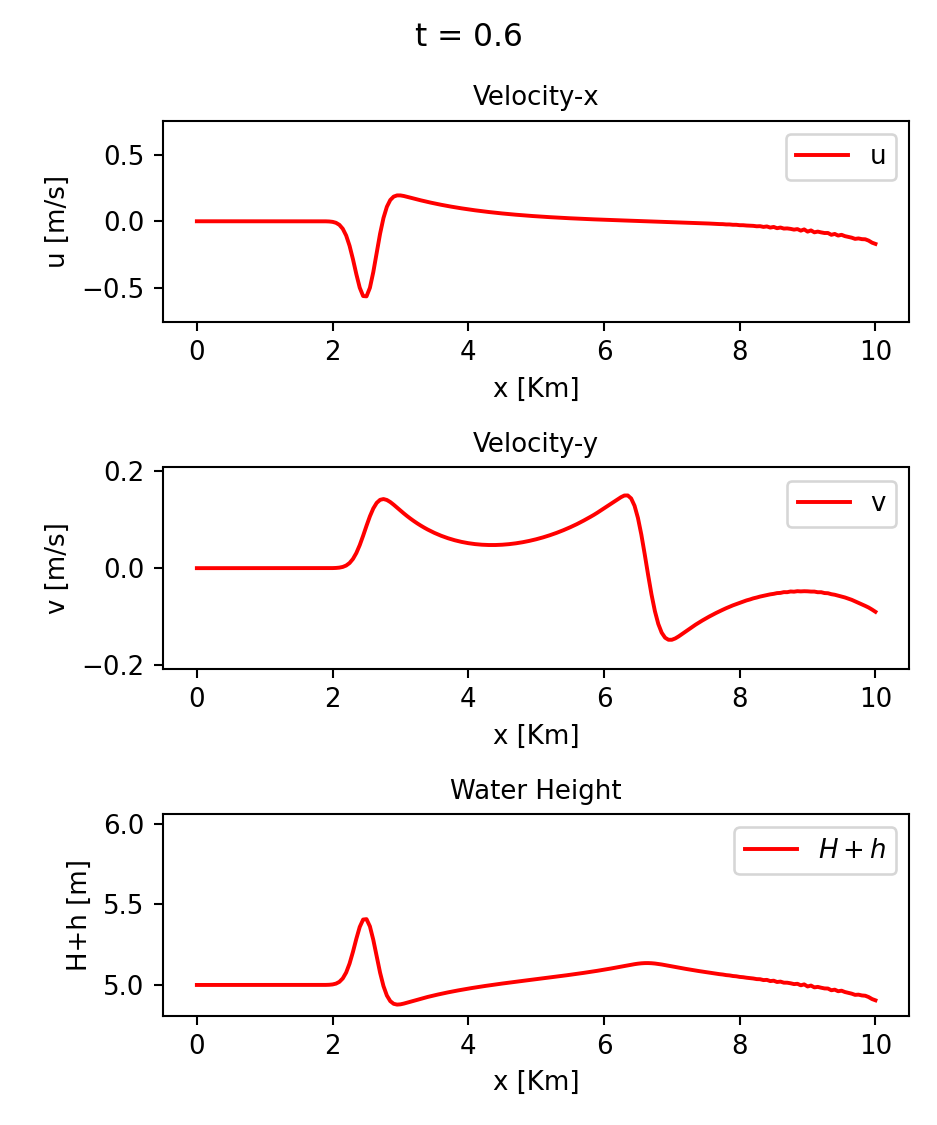

In [9]:
x = np.linspace(0, L, nx)

fig1 = plt.figure(figsize=(5,6))
ax1 = fig1.add_subplot(3,1,1)
line1 = ax1.plot(x, u, 'r', lw=1.5)
plt.title('Velocity-x', size=10)
ax1.legend(('u'))
plt.xlabel('x [Km]', size=10)
plt.ylabel('u [m/s]', size=10)

ax2 = fig1.add_subplot(3,1,2)
line2 = ax2.plot(x, v, 'r', lw=1.5)
plt.title('Velocity-y', size=10)
ax2.legend(('v'))
plt.xlabel('x [Km]', size=10)
plt.ylabel('v [m/s]', size=10)

ax3 = fig1.add_subplot(3,1,3)
line3 = ax3.plot(x, h+H,label=r'$H+h$', color='red', lw=1.5)
plt.title('Water Height', size=10)
ax3.legend()
plt.xlabel('x [Km]', size=10)
plt.ylabel('H+h [m]', size=10)

fig1.suptitle(f"t = {tend}")

plt.tight_layout()

plt.ion()                                                       # set interective mode
plt.show()

In [10]:
# initialise timer
start = timeit.default_timer()

# loop in time
x = np.linspace(0, L, nx)              # discrete domain
for t in drange(0, tend, dt):
    n = n+1
    #compute numerical solution
    
    u,v,h = RK4(u, v, h, nx, dx, dt, U, V, H, g, f, t, mms)
    
    # Exact solution
    u_e,v_e,h_e,f_u,f_v,f_h = 0*u,0*u,0*u,0*u,0*u,0*u
    if mms:
        u_e,v_e,h_e,f_u,f_v,f_h = mms_func(x,t+dt,U,V,H,g,f)
   
    T.append(t)
    # Updating plots
    if n % iplot == 0: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l

        if mms == True:
            line1 = ax1.plot(x, u, 'r', x, u_e,'k')
            ax1.legend(iter(line1),('u','u_e'))
            line2 = ax2.plot(x, v, 'r', x, v_e,'k')
            ax2.legend(iter(line2),('v','v_e'))
            line3 = ax3.plot(x, h+H, 'r', x, h_e+H,'k')
            ax3.legend(iter(line3),('h','h_e'))
        else:
            line1 = ax1.plot(x, u, 'r')
            ax1.legend(iter(line1),('u'))
            line2 = ax2.plot(x, v, 'r')
            ax2.legend(iter(line2),('v'))
            line3 = ax3.plot(x, h+H, 'r')
        
        plt.gcf().canvas.draw()
   
plt.ioff()
plt.show()

In [11]:
stop = timeit.default_timer()

print('total simulation time = ', stop - start, 's')            # print the time required for simulation
print('number of grid points = ', nx)                           # print the degree of freedom
print('uniform spatial step = ', dx, 'm')                      # print the spatial step

print('l2 error = ', np.sqrt(np.sum((u_e-u)**2)*dx+np.sum((v_e-v)**2)*dx+np.sum((h_e-h)**2)*dx))          # print the l2 error
print('log2 l2 error = ', np.log2(np.sqrt(np.sum((u_e-u)**2)*dx+np.sum((v_e-v)**2)*dx+np.sum((h_e-h)**2)*dx)))  # print the log2 of l2 error


total simulation time =  2.021836099999746 s
number of grid points =  201
uniform spatial step =  0.05 m
l2 error =  0.513042893595319
log2 l2 error =  -0.9628486456821216


In [2]:
#51
#l2 error =  0.01644689748358639
#log2 l2 error = -5.926040727831775

#101
#l2 error =  0.002114943736694434
#log2 l2 error =  -8.88516500045237
p1 = -5.926040727831775+8.88516500045237
print(p1)

#201
#l2 error =  0.00026719091346216403
#log2 l2 error =  -11.8698414335862
p2=-8.88516500045237+11.8698414335862
print(p2)

#401
#l2 error =  3.3548108860143953e-05
#log2 l2 error =  -14.863409031856063
p3 = -11.8698414335862+14.863409031856063
print(p3)

#801
#l2 error =  4.201472493361623e-06
#log2 l2 error =  -18.024998594473992
p4 = -14.863409031856063+17.860673530346062
print(p4)

grid_size = [0.2, 0.1, 0.05, 0.025, 0.0125]
error_vec_o4 = [0.01644689748358639, 0.002114943736694434, 0.00026719091346216403, 3.3548108860143953e-05, 4.201472493361623e-06]

2.9591242726205946
2.9846764331338314
2.9935675982698626
2.997264498489999


<IPython.core.display.Javascript object>


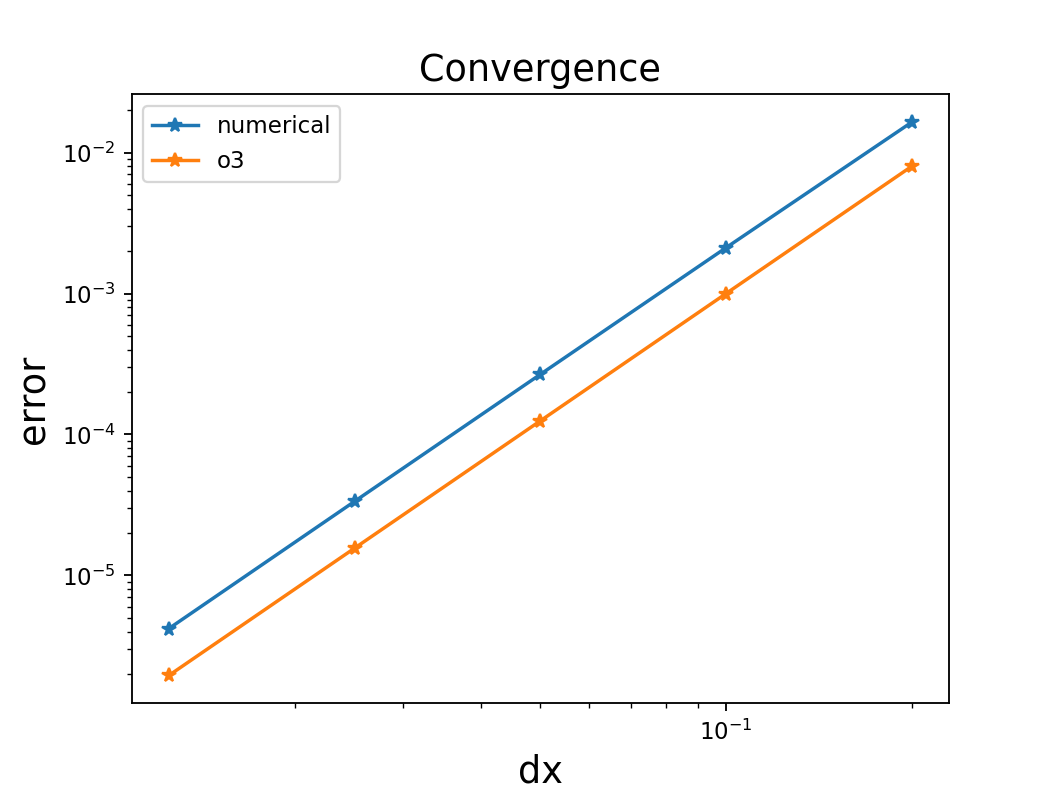

In [3]:
plt.plot(grid_size, error_vec_o4, '-*',grid_size, np.array(grid_size)**3, '-*')
plt.loglog()
plt.legend(('numerical','o3'))
plt.title('Convergence', fontsize=16)
plt.xlabel('dx', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()
